# Significance contours

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy.optimize as optimization
import pandas as pd
from curvefit import *
import sys
from matplotlib.colors import LogNorm

def func(x, a, b, c, d, e):
    return a + b*x + c*x*x + d*x*x*x + e*x*x*x*x

def Z(S,B):
    return S/np.sqrt(S+B)

def significance(XS,Eff,Lumi,TB):
    Evts=Lumi*(XS.transpose())*(Eff/100)
    return Z(Evts,TB)

def g(x,excl=5):
    return excl*np.ones_like(x)

# Full dataframe

Intersection of two graphs in Python: https://stackoverflow.com/a/28766902/2268280. See also: https://stackoverflow.com/a/31541338/2268280

## Full data with full luminosities for $M_{H^\pm}=700$ GeV

In [3]:
OLD=False
Zvv=500.
TB=Zvv/0.7

df=pd.DataFrame()
MHp=700 #MH+
#Lumis=[30000.,100000.,300000,500000,1000000,2000000,3000000.]
Lumis=range(30000,990000,10000)+range(1000000,3200000,20000)
LaL=np.array([0.01,0.02,0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,1.0,3.0,5.0,7.0,10.0])

if not OLD:
    #MH0=np.array([70,75,80,85,90,110,130,150,170,190,210,220,240,250,260,270,280,290,310,320,330,340,350])
    MH0=np.array([70,75,80,85,90,110,130,150,170,190,210,220,240,250,260,270,280,290,310,320,330,340,350,360,380,400,420,440,460,480,500])
    #XS=np.array([[0.0078360758,0.0074748213,0.0070754665,0.0067536191,0.0064510491,0.0054172973,0.0045051474,0.0037592107,0.0032054071,0.0026784861,0.0022766548,0.0020969754,0.0017517511,0.00158,0.001468,0.001332,0.001224,0.001107,0.0009433,0.0008677,0.0007995,0.0007326,0.0006703],[0.0082065086,0.0077708022,0.007349628,0.00693701,0.0066226838,0.0055226325,0.0045990578,0.0038483996,0.0032193226,0.0026657892,0.0022465378,0.0020644385,0.0017553319,0.001608,0.00147,0.001339,0.001236,0.001125,0.0009506,0.0008759,0.0008028,0.0007306,0.0006711],[0.0097703621,0.0088165001,0.0081364402,0.0076355136,0.0071975237,0.005774117,0.004747425,0.0039791989,0.0032831142,0.0027808124,0.0023150705,0.0021093137,0.0017759012,0.001623,0.001487,0.001369,0.001248,0.001145,0.0009613,0.0008975,0.0008237,0.0007599,0.0006953],[0.0114209102,0.0099172321,0.008989815,0.008275253,0.0076291179,0.0060410313,0.0049183178,0.0040736025,0.0033984916,0.0028252063,0.0023556713,0.0021598208,0.0018042345,0.001649,0.001523,0.001389,0.001274,0.001164,0.0009733,0.0008821,0.0008161,0.0007539,0.0006954],[0.0141261425,0.011538058,0.0100772508,0.0091387446,0.0083015654,0.0064056867,0.005105581,0.0041903605,0.0034603001,0.002874584,0.002399953,0.0021848377,0.0018426663,0.001686,0.001536,0.00142,0.001299,0.001183,0.0009947,0.0009072,0.000827,0.0007636,0.0006952],[0.0199244023,0.0150710533,0.0125500477,0.0109981421,0.0097669627,0.007093808,0.005426792,0.0044252381,0.0036370329,0.0029741967,0.0024921611,0.0022589091,0.0018830996,0.001722,0.00157,0.001446,0.001309,0.001207,0.0009938,0.0009116,0.0008335,0.0007761,0.0007062],[0.02718809,0.0197415176,0.0158114946,0.013315511,0.0117125411,0.0079966234,0.0060215445,0.0047304158,0.0038587394,0.0031590394,0.002542544,0.002339992,0.001943571,0.001781,0.001648,0.001467,0.001346,0.00123,0.001036,0.000954,0.0008832,0.0008031,0.0007327],[0.0368390613,0.0252109122,0.0194860982,0.0161147717,0.0137569482,0.0088156979,0.0064548956,0.0050120301,0.0040551356,0.0032343026,0.0026547231,0.0024302645,0.0019829646,0.001836,0.001678,0.001523,0.001401,0.001264,0.001048,0.0009617,0.0008759,0.0008055,0.0007529],[0.0477417696,0.0316975112,0.0238740798,0.0192376956,0.0161976628,0.0099808803,0.0071223902,0.0053884144,0.0042253186,0.0034186538,0.0027873166,0.0025091477,0.0020748118,0.001855,0.001692,0.001558,0.00141,0.001292,0.001081,0.000978,0.0008908,0.0008302,0.0007482],[0.0597594641,0.0391662561,0.0288215929,0.0226777226,0.0188525187,0.0111328469,0.0077551902,0.0057477354,0.0045193429,0.00355335,0.0028961628,0.0026179762,0.0021114508,0.001938,0.001762,0.001596,0.00146,0.001333,0.001105,0.001013,0.0009298,0.0008518,0.0007766],[0.074795661,0.0471382414,0.0344983622,0.0269670369,0.0218295048,0.0123661452,0.008372222,0.006092793,0.0047105712,0.0037799127,0.0029860606,0.0026812129,0.002195588,0.001984,0.001805,0.001639,0.001495,0.001357,0.001143,0.001044,0.0009418,0.0008667,0.0007912],[0.0910331288,0.056719572,0.0403238164,0.0310156215,0.0250082749,0.0136586156,0.009076643,0.0065809453,0.005000743,0.00392226,0.0031204184,0.0027715134,0.0022800071,0.002068,0.001856,0.001687,0.001525,0.001388,0.00116,0.001064,0.0009631,0.0008762,0.0008078],[0.1073493889,0.0656615482,0.0465501253,0.0360118243,0.0285769831,0.0150524151,0.009741139,0.0069750997,0.005314612,0.0040681959,0.0032409102,0.0029188355,0.002341286,0.002118,0.001911,0.00174,0.001571,0.001438,0.001196,0.001093,0.0009933,0.0008945,0.0008221],[0.1280433361,0.0776237164,0.0546097312,0.0411755041,0.0329947444,0.0168543256,0.0105431991,0.0075744427,0.0055587916,0.0043645989,0.0033693118,0.0030402861,0.0024380933,0.002199,0.001969,0.001797,0.001619,0.001475,0.001218,0.001114,0.001015,0.0009246,0.0008482],[0.1486951993,0.090430646,0.0626746388,0.046813216,0.0371150704,0.0184677209,0.0116123493,0.0080216444,0.0058224938,0.0045668647,0.0035358441,0.0031893159,0.0025571899,0.002314,0.002068,0.001875,0.001669,0.001533,0.001267,0.001147,0.001052,0.0009568,0.0008745],[0.3801513972,0.2204733474,0.1483789422,0.1065600252,0.0813605039,0.0363423812,0.0203569149,0.0130089521,0.0090585052,0.0065237688,0.0048930652,0.0042361239,0.0032936618,0.002918,0.002598,0.002333,0.002097,0.001895,0.001516,0.001362,0.001236,0.001128,0.001014],[3.2411847334,1.802126928,1.1724233011,0.8068670703,0.6031443333,0.2328728077,0.1148653527,0.0646187944,0.0396992648,0.0258472881,0.0176354822,0.0144681452,0.0104482974,0.008917,0.007751,0.006596,0.00569,0.005011,0.003844,0.003358,0.002969,0.002622,0.00233],[8.8942712763,4.9256158689,3.2191224508,2.2516554587,1.6631407483,0.6358005063,0.3074437758,0.1680084185,0.0996303322,0.0623872431,0.0417083023,0.0340446574,0.0238635636,0.02005,0.0169,0.01433,0.01229,0.01061,0.007881,0.006912,0.006068,0.005273,0.004634],[17.8456821254,10.0440353143,6.5685155591,4.6007698711,3.3960894709,1.2904938838,0.62990145,0.3405614304,0.1988306539,0.1251818318,0.082151307,0.0657439627,0.045381991,0.03777,0.03155,0.02671,0.02284,0.01934,0.01432,0.01248,0.0108,0.009329,0.008116],[38.1134563225,21.7394077983,14.2477022061,10.24165998,7.5844602442,2.9680190241,1.4428213268,0.7853725677,0.4556784552,0.2811727085,0.1813132612,0.1455257556,0.0986417774,0.08215,0.06913,0.0578,0.04885,0.04143,0.0299,0.02545,0.02192,0.01896,0.01638]])
    XS=np.array([[0.0078360758,0.0074748213,0.0070754665,0.0067536191,0.0064510491,0.0054172973,0.0045051474,0.0037592107,0.0032054071,0.0026784861,0.0022766548,0.0020969754,0.0017517511,0.00158,0.001468,0.001332,0.001224,0.001107,0.0009433,0.0008677,0.0007995,0.0007326,0.0006703,0.0006178817,0.0005198022,0.0004489262,0.000379377,0.0003248271,0.0002769444,0.0002384985,0.0002093498],[0.0082065086,0.0077708022,0.007349628,0.00693701,0.0066226838,0.0055226325,0.0045990578,0.0038483996,0.0032193226,0.0026657892,0.0022465378,0.0020644385,0.0017553319,0.001608,0.00147,0.001339,0.001236,0.001125,0.0009506,0.0008759,0.0008028,0.0007306,0.0006711,0.0006216894,0.0005275331,0.0004482344,0.000383939,0.0003239245,0.0002779885,0.0002383536,0.0002074641],[0.0097703621,0.0088165001,0.0081364402,0.0076355136,0.0071975237,0.005774117,0.004747425,0.0039791989,0.0032831142,0.0027808124,0.0023150705,0.0021093137,0.0017759012,0.001623,0.001487,0.001369,0.001248,0.001145,0.0009613,0.0008975,0.0008237,0.0007599,0.0006953,0.0006369339,0.0005298511,0.0004494483,0.0003868282,0.0003285306,0.0002803942,0.0002435354,0.000208461],[0.0114209102,0.0099172321,0.008989815,0.008275253,0.0076291179,0.0060410313,0.0049183178,0.0040736025,0.0033984916,0.0028252063,0.0023556713,0.0021598208,0.0018042345,0.001649,0.001523,0.001389,0.001274,0.001164,0.0009733,0.0008821,0.0008161,0.0007539,0.0006954,0.0006302737,0.0005391333,0.0004550232,0.000385657,0.000331161,0.0002841227,0.0002449257,0.000210208],[0.0141261425,0.011538058,0.0100772508,0.0091387446,0.0083015654,0.0064056867,0.005105581,0.0041903605,0.0034603001,0.002874584,0.002399953,0.0021848377,0.0018426663,0.001686,0.001536,0.00142,0.001299,0.001183,0.0009947,0.0009072,0.000827,0.0007636,0.0006952,0.0006396217,0.000535834,0.0004570827,0.0003917395,0.000332232,0.0002854172,0.0002457838,0.0002097435],[0.0199244023,0.0150710533,0.0125500477,0.0109981421,0.0097669627,0.007093808,0.005426792,0.0044252381,0.0036370329,0.0029741967,0.0024921611,0.0022589091,0.0018830996,0.001722,0.00157,0.001446,0.001309,0.001207,0.0009938,0.0009116,0.0008335,0.0007761,0.0007062,0.0006497107,0.0005537057,0.0004644396,0.0003984973,0.0003389937,0.0002888316,0.0002500202,0.0002147773],[0.02718809,0.0197415176,0.0158114946,0.013315511,0.0117125411,0.0079966234,0.0060215445,0.0047304158,0.0038587394,0.0031590394,0.002542544,0.002339992,0.001943571,0.001781,0.001648,0.001467,0.001346,0.00123,0.001036,0.000954,0.0008832,0.0008031,0.0007327,0.0006669626,0.0005611252,0.0004732005,0.0004001924,0.0003436386,0.0002946985,0.0002521648,0.0002157378],[0.0368390613,0.0252109122,0.0194860982,0.0161147717,0.0137569482,0.0088156979,0.0064548956,0.0050120301,0.0040551356,0.0032343026,0.0026547231,0.0024302645,0.0019829646,0.001836,0.001678,0.001523,0.001401,0.001264,0.001048,0.0009617,0.0008759,0.0008055,0.0007529,0.0006864561,0.0005774351,0.0004843243,0.0004095844,0.0003479924,0.0002958062,0.0002521645,0.0002178914],[0.0477417696,0.0316975112,0.0238740798,0.0192376956,0.0161976628,0.0099808803,0.0071223902,0.0053884144,0.0042253186,0.0034186538,0.0027873166,0.0025091477,0.0020748118,0.001855,0.001692,0.001558,0.00141,0.001292,0.001081,0.000978,0.0008908,0.0008302,0.0007482,0.0006914935,0.0005751229,0.000490771,0.000412552,0.0003481144,0.0003034784,0.0002598552,0.0002207327],[0.0597594641,0.0391662561,0.0288215929,0.0226777226,0.0188525187,0.0111328469,0.0077551902,0.0057477354,0.0045193429,0.00355335,0.0028961628,0.0026179762,0.0021114508,0.001938,0.001762,0.001596,0.00146,0.001333,0.001105,0.001013,0.0009298,0.0008518,0.0007766,0.0007064444,0.0005935089,0.0005012611,0.0004238343,0.0003621581,0.0003036765,0.0002594389,0.0002217333],[0.074795661,0.0471382414,0.0344983622,0.0269670369,0.0218295048,0.0123661452,0.008372222,0.006092793,0.0047105712,0.0037799127,0.0029860606,0.0026812129,0.002195588,0.001984,0.001805,0.001639,0.001495,0.001357,0.001143,0.001044,0.0009418,0.0008667,0.0007912,0.0007323121,0.000603804,0.0005074404,0.0004293521,0.0003658681,0.0003092368,0.0002641046,0.0002259793],[0.0910331288,0.056719572,0.0403238164,0.0310156215,0.0250082749,0.0136586156,0.009076643,0.0065809453,0.005000743,0.00392226,0.0031204184,0.0027715134,0.0022800071,0.002068,0.001856,0.001687,0.001525,0.001388,0.00116,0.001064,0.0009631,0.0008762,0.0008078,0.0007409797,0.0006190685,0.0005152277,0.0004364468,0.000370098,0.0003152642,0.0002690985,0.0002313259],[0.1073493889,0.0656615482,0.0465501253,0.0360118243,0.0285769831,0.0150524151,0.009741139,0.0069750997,0.005314612,0.0040681959,0.0032409102,0.0029188355,0.002341286,0.002118,0.001911,0.00174,0.001571,0.001438,0.001196,0.001093,0.0009933,0.0008945,0.0008221,0.0007505776,0.0006308229,0.0005317223,0.0004463966,0.0003757861,0.0003205145,0.0002730925,0.0002330485],[0.1280433361,0.0776237164,0.0546097312,0.0411755041,0.0329947444,0.0168543256,0.0105431991,0.0075744427,0.0055587916,0.0043645989,0.0033693118,0.0030402861,0.0024380933,0.002199,0.001969,0.001797,0.001619,0.001475,0.001218,0.001114,0.001015,0.0009246,0.0008482,0.0007763226,0.0006425923,0.0005409277,0.0004550351,0.000384326,0.0003226415,0.0002737596,0.0002335593],[0.1486951993,0.090430646,0.0626746388,0.046813216,0.0371150704,0.0184677209,0.0116123493,0.0080216444,0.0058224938,0.0045668647,0.0035358441,0.0031893159,0.0025571899,0.002314,0.002068,0.001875,0.001669,0.001533,0.001267,0.001147,0.001052,0.0009568,0.0008745,0.000790781,0.0006643115,0.0005560378,0.0004679073,0.0003930493,0.0003282094,0.0002781909,0.0002386514],[0.3801513972,0.2204733474,0.1483789422,0.1065600252,0.0813605039,0.0363423812,0.0203569149,0.0130089521,0.0090585052,0.0065237688,0.0048930652,0.0042361239,0.0032936618,0.002918,0.002598,0.002333,0.002097,0.001895,0.001516,0.001362,0.001236,0.001128,0.001014,0.0009170711,0.000768487,0.0006371682,0.0005332837,0.0004463223,0.0003695104,0.0003126501,0.0002644134],[3.2411847334,1.802126928,1.1724233011,0.8068670703,0.6031443333,0.2328728077,0.1148653527,0.0646187944,0.0396992648,0.0258472881,0.0176354822,0.0144681452,0.0104482974,0.008917,0.007751,0.006596,0.00569,0.005011,0.003844,0.003358,0.002969,0.002622,0.00233,0.002064297,0.0016383876,0.0013304562,0.0010728608,0.0008739,0.0007156557,0.0005886708,0.0004844853],[8.8942712763,4.9256158689,3.2191224508,2.2516554587,1.6631407483,0.6358005063,0.3074437758,0.1680084185,0.0996303322,0.0623872431,0.0417083023,0.0340446574,0.0238635636,0.02005,0.0169,0.01433,0.01229,0.01061,0.007881,0.006912,0.006068,0.005273,0.004634,0.0040934753,0.0031791645,0.0024886133,0.0019791071,0.0015790843,0.0012655202,0.0010262167,0.0008320174],[17.8456821254,10.0440353143,6.5685155591,4.6007698711,3.3960894709,1.2904938838,0.62990145,0.3405614304,0.1988306539,0.1251818318,0.082151307,0.0657439627,0.045381991,0.03777,0.03155,0.02671,0.02284,0.01934,0.01432,0.01248,0.0108,0.009329,0.008116,0.0071408019,0.0054673114,0.0042327745,0.0033255497,0.0026507255,0.0021136729,0.0016881604,0.0013569229],[38.1134563225,21.7394077983,14.2477022061,10.24165998,7.5844602442,2.9680190241,1.4428213268,0.7853725677,0.4556784552,0.2811727085,0.1813132612,0.1455257556,0.0986417774,0.08215,0.06913,0.0578,0.04885,0.04143,0.0299,0.02545,0.02192,0.01896,0.01638,0.0143424426,0.0109550568,0.0084686694,0.0065238889,0.005120414,0.0040415172,0.003209806,0.0025624249]])
    #Eff=np.array([[3.199174406604747, 4.43298969072165, 4.375, 3.008298755186722, 3.441084462982273, 3.067484662576687, 2.2082018927444795, 2.57201646090535, 1.9874476987447698, 1.8518518518518519, 2.57201646090535, 1.875, 1.981230448383733, 1.7782426778242677, 1.7838405036726128, 1.36986301369863, 1.2435233160621761, 1.256544502617801, 1.365546218487395, 1.0298661174047374],[4.241781548250265, 5.613305613305613, 4.016477857878476, 3.0239833159541187, 3.757828810020877, 2.7921406411582215, 3.125, 2.4870466321243523, 2.8095733610822062, 2.059732234809475, 3.490759753593429, 1.975051975051975, 1.5608740894901145, 1.4492753623188406, 1.9668737060041408, 1.4462809917355373, 1.7400204708290685, 1.954732510288066, 1.1506276150627615, 1.1482254697286012],[4.895833333333333, 3.4627492130115427, 4.712041884816754, 3.7735849056603774, 4.0582726326742975, 3.913491246138002, 3.586497890295359, 3.638253638253638, 3.4161490683229814, 3.209109730848861, 2.286902286902287, 2.47167868177137, 2.9804727646454263, 2.5906735751295336, 2.1761658031088085, 1.5657620041753653, 1.8691588785046729, 1.4553014553014554, 2.0876826722338206, 1.251303441084463],[5.3125, 6.145833333333333, 4.692387904066736, 4.075235109717869, 4.597701149425287, 3.653444676409186, 3.1023784901758016, 3.402061855670103, 4.253112033195021, 4.024767801857585, 3.8906414300736065, 3.0239833159541187, 3.2528856243441764, 3.2854209445585214, 3.490759753593429, 2.36382322713258, 2.7720739219712525, 1.3388259526261586, 1.5511892450879008, 1.9467213114754098],[4.149377593360996, 4.416403785488959, 4.6777546777546775, 4.054054054054054, 5.174234424498416, 4.248704663212435, 3.426791277258567, 3.3057851239669422, 3.6496350364963503, 2.272727272727273, 2.7139874739039667, 4.028925619834711, 3.319502074688797, 2.711157455683003, 3.209109730848861, 2.9958677685950414, 2.4896265560165975, 2.2540983606557377, 2.277432712215321, 1.3238289205702647],[4.266389177939646, 5.104166666666667, 5.056759545923633, 4.855371900826446, 5.925155925155925, 6.029106029106029, 5.405405405405405, 3.9337474120082816, 5.882352941176471, 4.024767801857585, 3.711340206185567, 3.112033195020747, 2.883625128733265, 4.72764645426516, 2.7892561983471076, 3.4232365145228214, 2.8125, 2.158273381294964, 1.5432098765432098, 1.842374616171955],[4.878048780487805, 4.179728317659352, 6.139438085327783, 5.077720207253886, 5.807814149947202, 6.340956340956341, 4.916317991631799, 4.158004158004158, 4.488517745302714, 5.318039624608968, 4.583333333333333, 4.126984126984127, 4.612159329140461, 3.905447070914697, 4.564315352697095, 3.374233128834356, 3.58974358974359, 2.6859504132231407, 2.4691358024691357, 1.8329938900203666],[4.1623309053069715, 5.090137857900318, 4.680851063829787, 7.142857142857143, 5.7591623036649215, 4.702194357366771, 5.2301255230125525, 5.735140771637122, 5.192107995846314, 5.648535564853557, 6.521739130434782, 5.104166666666667, 4.72193074501574, 4.2752867570385815, 3.7267080745341614, 3.4161490683229814, 3.4055727554179565, 2.674897119341564, 3.501544799176107, 1.629327902240326],[5.186721991701245, 5.175983436853002, 6.15866388308977, 5.38860103626943, 4.311251314405888, 3.473684210526316, 4.512067156348373, 5.08298755186722, 5.175983436853002, 6.204756980351603, 5.77124868835257, 4.235537190082645, 4.947368421052632, 4.8353909465020575, 4.658385093167702, 3.7460978147762747, 3.29557157569516, 2.579979360165119, 1.954732510288066, 1.5337423312883436],[6.673728813559322, 4.439746300211416, 5.857740585774058, 5.654450261780105, 5.69620253164557, 5.2356020942408374, 5.931321540062435, 4.668049792531121, 5.503634475597092, 4.916317991631799, 4.826862539349423, 5.136268343815513, 4.916317991631799, 4.569055036344756, 4.583333333333333, 5.104166666666667, 3.9215686274509802, 3.822314049586777, 2.263374485596708, 1.9387755102040816],[6.327800829875518, 5.077720207253886, 4.041450777202073, 6.309148264984227, 4.811715481171548, 3.907074973600845, 5.968586387434555, 4.483837330552659, 5.093555093555094, 5.077720207253886, 5.042016806722689, 4.7418335089567965, 6.1139896373057, 5.279503105590062, 5.584281282316443, 4.66321243523316, 3.71900826446281, 4.123711340206185, 3.4161490683229814, 2.7522935779816513],[5.368421052631579, 4.682622268470343, 4.72193074501574, 5.306971904266389, 5.368421052631579, 4.953560371517028, 6.197478991596639, 4.756980351602896, 5.368421052631579, 5.29595015576324, 7.210031347962382, 5.031446540880503, 4.6875, 7.596253902185223, 5.9436913451511995, 5.093555093555094, 3.9542143600416235, 3.508771929824561, 3.172978505629478, 3.711340206185567],[4.636459430979979, 5.219206680584551, 4.994686503719447, 4.37956204379562, 5.46218487394958, 6.342494714587738, 5.7591623036649215, 5.543933054393306, 6.282722513089006, 5.7531380753138075, 4.931794333683106, 5.323590814196242, 5.96234309623431, 5.383022774327122, 4.831932773109243, 5.8212058212058215, 4.747162022703819, 4.410256410256411, 2.7720739219712525, 3.873598369011213],[5.2854122621564485, 4.707112970711297, 5.229455709711846, 4.578563995837669, 5.738575982996812, 5.70221752903907, 5.47945205479452, 5.329153605015674, 6.867845993756504, 5.306971904266389, 5.357142857142857, 4.791666666666667, 6.092436974789916, 4.668049792531121, 5.130890052356021, 6.004140786749482, 4.948453608247423, 4.205128205128205, 3.080082135523614, 3.873598369011213],[5.496828752642706, 5.175983436853002, 5.032119914346895, 4.786680541103018, 5.63230605738576, 5.894736842105263, 5.257623554153523, 4.911180773249739, 6.694560669456067, 5.219206680584551, 5.6426332288401255, 4.648760330578512, 5.987394957983193, 4.766839378238342, 5.246589716684155, 5.648535564853557, 5.0463439752832135, 3.8065843621399176, 3.1762295081967213, 3.564154786150713],[5.6722689075630255, 4.870466321243524, 6.038135593220339, 5.197505197505198, 5.2631578947368425, 5.813953488372093, 5.257623554153523, 5.839416058394161, 6.8277310924369745, 4.821802935010482, 5.026178010471204, 4.668049792531121, 5.82726326742976, 4.682622268470343, 4.40251572327044, 6.40083945435467, 5.349794238683128, 4.22680412371134, 3.9296794208893484, 4.077471967380224],[5.157894736842105, 4.564315352697095, 5.6203605514316015, 4.911180773249739, 5.783385909568874, 6.567796610169491, 5.456453305351522, 5.735140771637122, 6.882168925964546, 5.340314136125654, 5.7591623036649215, 4.175365344467641, 6.918238993710692, 4.938271604938271, 4.602510460251046, 6.4278187565858795, 4.974093264248705, 4.213771839671121, 3.0927835051546393, 3.763987792472024],[5.368421052631579, 4.66321243523316, 6.1440677966101696, 5.010438413361169, 5.345911949685535, 6.044538706256628, 5.379746835443038, 5.329153605015674, 6.360792492179353, 5.422314911366006, 5.561385099685205, 4.3478260869565215, 6.066945606694561, 4.4421487603305785, 4.602510460251046, 6.471816283924843, 4.75206611570248, 4.605936540429887, 3.2753326509723646, 3.669724770642202],[5.900948366701791, 4.984423676012461, 5.207226354941551, 5.3125, 5.439330543933054, 6.269925611052073, 5.690200210748156, 5.845511482254698, 6.465067778936392, 5.405405405405405, 5.3627760252365935, 4.890738813735692, 6.701570680628272, 4.75206611570248, 4.811715481171548, 5.956112852664577, 4.948453608247423, 3.6231884057971016, 2.883625128733265, 3.9634146341463414],[5.05795574288725, 4.361370716510903, 5.520169851380042, 5.439330543933054, 5.307855626326964, 5.913410770855332, 5.6203605514316015, 5.783385909568874, 6.777893639207508, 5.2246603970741905, 6.054279749478079, 4.6875, 7.052631578947368, 5.056759545923633, 4.5073375262054505, 5.9375, 5.2631578947368425, 3.5860655737704916, 2.9804727646454263, 3.873598369011213],[5.3627760252365935, 4.963805584281283, 5.414012738853503, 5.399792315680166, 6.012658227848101, 6.786850477200424, 5.690200210748156, 5.345911949685535, 7.41901776384535, 4.451345755693581, 5.334728033472803, 4.766839378238342, 5.6426332288401255, 4.43298969072165, 4.791666666666667, 5.839416058394161, 5.2631578947368425, 3.6998972250770814, 3.1893004115226335, 3.4552845528455283],[5.807814149947202, 5.3125, 5.218317358892439, 5.109489051094891, 5.7894736842105265, 6.118143459915612, 5.807814149947202, 5.654450261780105, 7.12041884816754, 4.984423676012461, 5.340314136125654, 4.766839378238342, 5.578947368421052, 5.268595041322314, 4.479166666666667, 5.9436913451511995, 5.154639175257732, 3.6082474226804124, 2.865916069600819, 3.673469387755102],[4.811715481171548, 4.672897196261682, 5.090137857900318, 4.979253112033195, 6.190975865687303, 5.993690851735016, 5.052631578947368, 5.439330543933054, 7.090719499478624, 4.895833333333333, 5.6426332288401255, 4.761904761904762, 5.625, 4.658385093167702, 4.826862539349423, 5.549738219895288, 5.1493305870236865, 3.9215686274509802, 2.8776978417266186, 3.564154786150713]])
    Eff=np.array([[3.199174406604747, 4.43298969072165, 4.375, 3.008298755186722, 3.441084462982273, 3.067484662576687, 2.2082018927444795, 2.57201646090535, 1.9874476987447698, 1.8518518518518519, 2.57201646090535, 1.875, 1.981230448383733, 1.7782426778242677, 1.7838405036726128, 1.36986301369863, 1.2435233160621761, 1.256544502617801, 1.365546218487395, 1.0298661174047374],[4.241781548250265, 5.613305613305613, 4.016477857878476, 3.0239833159541187, 3.757828810020877, 2.7921406411582215, 3.125, 2.4870466321243523, 2.8095733610822062, 2.059732234809475, 3.490759753593429, 1.975051975051975, 1.5608740894901145, 1.4492753623188406, 1.9668737060041408, 1.4462809917355373, 1.7400204708290685, 1.954732510288066, 1.1506276150627615, 1.1482254697286012],[4.895833333333333, 3.4627492130115427, 4.712041884816754, 3.7735849056603774, 4.0582726326742975, 3.913491246138002, 3.586497890295359, 3.638253638253638, 3.4161490683229814, 3.209109730848861, 2.286902286902287, 2.47167868177137, 2.9804727646454263, 2.5906735751295336, 2.1761658031088085, 1.5657620041753653, 1.8691588785046729, 1.4553014553014554, 2.0876826722338206, 1.251303441084463],[5.3125, 6.145833333333333, 4.692387904066736, 4.075235109717869, 4.597701149425287, 3.653444676409186, 3.1023784901758016, 3.402061855670103, 4.253112033195021, 4.024767801857585, 3.8906414300736065, 3.0239833159541187, 3.2528856243441764, 3.2854209445585214, 3.490759753593429, 2.36382322713258, 2.7720739219712525, 1.3388259526261586, 1.5511892450879008, 1.9467213114754098],[4.149377593360996, 4.416403785488959, 4.6777546777546775, 4.054054054054054, 5.174234424498416, 4.248704663212435, 3.426791277258567, 3.3057851239669422, 3.6496350364963503, 2.272727272727273, 2.7139874739039667, 4.028925619834711, 3.319502074688797, 2.711157455683003, 3.209109730848861, 2.9958677685950414, 2.4896265560165975, 2.2540983606557377, 2.277432712215321, 1.3238289205702647],[4.266389177939646, 5.104166666666667, 5.056759545923633, 4.855371900826446, 5.925155925155925, 6.029106029106029, 5.405405405405405, 3.9337474120082816, 5.882352941176471, 4.024767801857585, 3.711340206185567, 3.112033195020747, 2.883625128733265, 4.72764645426516, 2.7892561983471076, 3.4232365145228214, 2.8125, 2.158273381294964, 1.5432098765432098, 1.842374616171955],[4.878048780487805, 4.179728317659352, 6.139438085327783, 5.077720207253886, 5.807814149947202, 6.340956340956341, 4.916317991631799, 4.158004158004158, 4.488517745302714, 5.318039624608968, 4.583333333333333, 4.126984126984127, 4.612159329140461, 3.905447070914697, 4.564315352697095, 3.374233128834356, 3.58974358974359, 2.6859504132231407, 2.4691358024691357, 1.8329938900203666],[4.1623309053069715, 5.090137857900318, 4.680851063829787, 7.142857142857143, 5.7591623036649215, 4.702194357366771, 5.2301255230125525, 5.735140771637122, 5.192107995846314, 5.648535564853557, 6.521739130434782, 5.104166666666667, 4.72193074501574, 4.2752867570385815, 3.7267080745341614, 3.4161490683229814, 3.4055727554179565, 2.674897119341564, 3.501544799176107, 1.629327902240326],[5.186721991701245, 5.175983436853002, 6.15866388308977, 5.38860103626943, 4.311251314405888, 3.473684210526316, 4.512067156348373, 5.08298755186722, 5.175983436853002, 6.204756980351603, 5.77124868835257, 4.235537190082645, 4.947368421052632, 4.8353909465020575, 4.658385093167702, 3.7460978147762747, 3.29557157569516, 2.579979360165119, 1.954732510288066, 1.5337423312883436],[6.673728813559322, 4.439746300211416, 5.857740585774058, 5.654450261780105, 5.69620253164557, 5.2356020942408374, 5.931321540062435, 4.668049792531121, 5.503634475597092, 4.916317991631799, 4.826862539349423, 5.136268343815513, 4.916317991631799, 4.569055036344756, 4.583333333333333, 5.104166666666667, 3.9215686274509802, 3.822314049586777, 2.263374485596708, 1.9387755102040816],[6.327800829875518, 5.077720207253886, 4.041450777202073, 6.309148264984227, 4.811715481171548, 3.907074973600845, 5.968586387434555, 4.483837330552659, 5.093555093555094, 5.077720207253886, 5.042016806722689, 4.7418335089567965, 6.1139896373057, 5.279503105590062, 5.584281282316443, 4.66321243523316, 3.71900826446281, 4.123711340206185, 3.4161490683229814, 2.7522935779816513],[5.368421052631579, 4.682622268470343, 4.72193074501574, 5.306971904266389, 5.368421052631579, 4.953560371517028, 6.197478991596639, 4.756980351602896, 5.368421052631579, 5.29595015576324, 7.210031347962382, 5.031446540880503, 4.6875, 7.596253902185223, 5.9436913451511995, 5.093555093555094, 3.9542143600416235, 3.508771929824561, 3.172978505629478, 3.711340206185567],[4.636459430979979, 5.219206680584551, 4.994686503719447, 4.37956204379562, 5.46218487394958, 6.342494714587738, 5.7591623036649215, 5.543933054393306, 6.282722513089006, 5.7531380753138075, 4.931794333683106, 5.323590814196242, 5.96234309623431, 5.383022774327122, 4.831932773109243, 5.8212058212058215, 4.747162022703819, 4.410256410256411, 2.7720739219712525, 3.873598369011213],[5.2854122621564485, 4.707112970711297, 5.229455709711846, 4.578563995837669, 5.738575982996812, 5.70221752903907, 5.47945205479452, 5.329153605015674, 6.867845993756504, 5.306971904266389, 5.357142857142857, 4.791666666666667, 6.092436974789916, 4.668049792531121, 5.130890052356021, 6.004140786749482, 4.948453608247423, 4.205128205128205, 3.080082135523614, 3.873598369011213],[5.496828752642706, 5.175983436853002, 5.032119914346895, 4.786680541103018, 5.63230605738576, 5.894736842105263, 5.257623554153523, 4.911180773249739, 6.694560669456067, 5.219206680584551, 5.6426332288401255, 4.648760330578512, 5.987394957983193, 4.766839378238342, 5.246589716684155, 5.648535564853557, 5.0463439752832135, 3.8065843621399176, 3.1762295081967213, 3.564154786150713],[5.6722689075630255, 4.870466321243524, 6.038135593220339, 5.197505197505198, 5.2631578947368425, 5.813953488372093, 5.257623554153523, 5.839416058394161, 6.8277310924369745, 4.821802935010482, 5.026178010471204, 4.668049792531121, 5.82726326742976, 4.682622268470343, 4.40251572327044, 6.40083945435467, 5.349794238683128, 4.22680412371134, 3.9296794208893484, 4.077471967380224],[5.157894736842105, 4.564315352697095, 5.6203605514316015, 4.911180773249739, 5.783385909568874, 6.567796610169491, 5.456453305351522, 5.735140771637122, 6.882168925964546, 5.340314136125654, 5.7591623036649215, 4.175365344467641, 6.918238993710692, 4.938271604938271, 4.602510460251046, 6.4278187565858795, 4.974093264248705, 4.213771839671121, 3.0927835051546393, 3.763987792472024],[5.368421052631579, 4.66321243523316, 6.1440677966101696, 5.010438413361169, 5.345911949685535, 6.044538706256628, 5.379746835443038, 5.329153605015674, 6.360792492179353, 5.422314911366006, 5.561385099685205, 4.3478260869565215, 6.066945606694561, 4.4421487603305785, 4.602510460251046, 6.471816283924843, 4.75206611570248, 4.605936540429887, 3.2753326509723646, 3.669724770642202],[5.900948366701791, 4.984423676012461, 5.207226354941551, 5.3125, 5.439330543933054, 6.269925611052073, 5.690200210748156, 5.845511482254698, 6.465067778936392, 5.405405405405405, 5.3627760252365935, 4.890738813735692, 6.701570680628272, 4.75206611570248, 4.811715481171548, 5.956112852664577, 4.948453608247423, 3.6231884057971016, 2.883625128733265, 3.9634146341463414],[5.05795574288725, 4.361370716510903, 5.520169851380042, 5.439330543933054, 5.307855626326964, 5.913410770855332, 5.6203605514316015, 5.783385909568874, 6.777893639207508, 5.2246603970741905, 6.054279749478079, 4.6875, 7.052631578947368, 5.056759545923633, 4.5073375262054505, 5.9375, 5.2631578947368425, 3.5860655737704916, 2.9804727646454263, 3.873598369011213],[5.3627760252365935, 4.963805584281283, 5.414012738853503, 5.399792315680166, 6.012658227848101, 6.786850477200424, 5.690200210748156, 5.345911949685535, 7.41901776384535, 4.451345755693581, 5.334728033472803, 4.766839378238342, 5.6426332288401255, 4.43298969072165, 4.791666666666667, 5.839416058394161, 5.2631578947368425, 3.6998972250770814, 3.1893004115226335, 3.4552845528455283],[5.807814149947202, 5.3125, 5.218317358892439, 5.109489051094891, 5.7894736842105265, 6.118143459915612, 5.807814149947202, 5.654450261780105, 7.12041884816754, 4.984423676012461, 5.340314136125654, 4.766839378238342, 5.578947368421052, 5.268595041322314, 4.479166666666667, 5.9436913451511995, 5.154639175257732, 3.6082474226804124, 2.865916069600819, 3.673469387755102],[4.811715481171548, 4.672897196261682, 5.090137857900318, 4.979253112033195, 6.190975865687303, 5.993690851735016, 5.052631578947368, 5.439330543933054, 7.090719499478624, 4.895833333333333, 5.6426332288401255, 4.761904761904762, 5.625, 4.658385093167702, 4.826862539349423, 5.549738219895288, 5.1493305870236865, 3.9215686274509802, 2.8776978417266186, 3.564154786150713],[4.942166140904312, 5.561385099685205, 4.550264550264551, 4.201680672268908, 4.268943436499466, 5.680600214362272, 4.631578947368421, 4.862579281183932, 4.857444561774023, 4.366347177848775, 4.641350210970464, 5.59662090813094, 5.70221752903907, 6.765327695560254, 3.5940803382663846, 6.617647058823529, 5.555555555555555, 4.653567735263702, 4.192229038854806, 4.503582395087001],[4.17558886509636, 4.550264550264551, 5.555555555555555, 4.2283298097251585, 4.621848739495798, 4.741379310344827, 4.909284951974386, 5.336179295624333, 4.736275565123789, 4.900938477580813, 5.8760683760683765, 4.021164021164021, 6.236786469344609, 5.795574288724974, 3.466386554621849, 5.329153605015674, 4.963805584281283, 3.9419087136929463, 4.815573770491803, 3.7948717948717947],[4.823151125401929, 3.8014783526927136, 4.545454545454546, 4.430379746835443, 5.0106609808102345, 4.357066950053135, 5.2631578947368425, 4.621848739495798, 3.9361702127659575, 4.371002132196162, 4.680851063829787, 4.741379310344827, 6.2302006335797255, 3.441084462982273, 4.665959703075291, 4.702194357366771, 5.473684210526316, 3.68474923234391, 4.320987654320987, 3.182751540041068],[4.180064308681672, 3.987408184679958, 4.246284501061571, 4.468085106382978, 4.075235109717869, 5.229455709711846, 3.540772532188841, 4.148936170212766, 3.898840885142255, 5.179704016913319, 5.047318611987381, 5.246589716684155, 6.111696522655427, 5.756929637526652, 4.171122994652406, 4.6267087276550996, 4.578563995837669, 3.5196687370600412, 4.3254376930998975, 3.877551020408163],[3.0752916224814424, 3.7735849056603774, 2.962962962962963, 3.3513513513513513, 2.981895633652822, 3.8297872340425534, 4.73186119873817, 4.540654699049631, 4.641350210970464, 4.685835995740149, 4.7418335089567965, 3.1914893617021276, 3.9278131634819533, 3.3084311632870866, 5.036726128016789, 3.5789473684210527, 4.365904365904366, 4.320987654320987, 4.132231404958677, 3.172978505629478],[4.5358649789029535, 3.2804232804232805, 2.857142857142857, 4.2887029288702925, 2.774813233724653, 3.5789473684210527, 2.6595744680851063, 2.4704618689581097, 3.755364806866953, 3.8906414300736065, 3.1082529474812435, 2.9661016949152543, 3.862212943632568, 2.9166666666666665, 4.569606801275239, 3.6958817317845827, 4.40251572327044, 4.1450777202072535, 5.107252298263535, 4.285714285714286],[3.8054968287526427, 3.4151547491995733, 2.8846153846153846, 3.06553911205074, 2.742616033755274, 3.1914893617021276, 3.3155080213903743, 3.3578174186778593, 2.2151898734177213, 4.487179487179487, 3.492063492063492, 2.4520255863539444, 3.5106382978723403, 2.2245762711864407, 3.8541666666666665, 5.168776371308017, 5.46218487394958, 5.383022774327122, 3.278688524590164, 4.7082906857727735],[2.5613660618996796, 2.3182297154899896, 2.6852846401718584, 2.8846153846153846, 3.0366492146596857, 2.848101265822785, 2.433862433862434, 2.3479188900747063, 2.620545073375262, 3.361344537815126, 3.290870488322718, 2.6288117770767614, 3.5714285714285716, 3.488372093023256, 3.62087326943557, 3.3368091762252345, 3.8541666666666665, 2.8629856850715747, 4.43298969072165, 3.4943473792394655]])
        
else:
    MH0=np.array([70,75,80,85,90,110,130,150,170,190,210,220,240])
    XS=np.array([[0.00783607575629,0.00747482126337,0.0070754665236,0.0067536191246,0.0064510490936,0.00541729727502,0.00450514743728,0.00375921068237,0.00320540710897,0.00267848607156,0.00227665480784,0.00209697543768,0.00175175111731],[0.00820650858184,0.00777080218416,0.00734962798323,0.0069370100351,0.0066226838262,0.00552263250849,0.00459905776702,0.00384839961038,0.00321932258602,0.00266578919844,0.00224653784862,0.00206443852413,0.00175533185608],[0.00977036213144,0.00881650013264,0.00813644023049,0.00763551355176,0.00719752367893,0.00577411696313,0.00474742502055,0.00397919891226,0.00328311418054,0.00278081244384,0.00231507054359,0.00210931366709,0.00177590124026],[0.011420910156,0.00991723213372,0.0089898149608,0.00827525303364,0.00762911789735,0.00604103126321,0.00491831776786,0.00407360249129,0.00339849158687,0.00282520633474,0.00235567126882,0.00215982084251,0.00180423451155],[0.0141261425284,0.0115380580022,0.0100772508372,0.00913874460108,0.00830156542016,0.00640568666986,0.00510558102448,0.00419036053004,0.00346030010049,0.0028745840313,0.00239995296473,0.00218483771474,0.00184266632757],[0.0199244023107,0.0150710532694,0.0125500477084,0.0109981420566,0.00976696266413,0.0070938080392,0.00542679204951,0.00442523806302,0.00363703285801,0.00297419670822,0.00249216109259,0.00225890914297,0.00188309960197],[0.0271880899908,0.0197415176028,0.0158114945573,0.0133155110342,0.0117125410659,0.00799662341219,0.00602154446212,0.00473041583628,0.00385873942405,0.00315903944048,0.00254254399698,0.00233999204944,0.00194357104849],[0.0368390612651,0.0252109121861,0.0194860982444,0.0161147716505,0.0137569481748,0.00881569794804,0.0064548956078,0.005012030082,0.00405513563802,0.00323430260427,0.00265472306713,0.00243026454045,0.0019829645914],[0.0477417695661,0.0316975111695,0.0238740797744,0.0192376955626,0.0161976627504,0.00998088027677,0.00712239023152,0.00538841435699,0.00422531855685,0.00341865377609,0.00278731658182,0.00250914774171,0.00207481178219],[0.0597594640654,0.0391662561018,0.028821592883,0.022677722633,0.0188525187018,0.0111328469037,0.00775519019637,0.00574773540242,0.00451934291073,0.00355335003647,0.00289616277128,0.00261797622203,0.0021114508465],[0.0747956609518,0.0471382414448,0.0344983621758,0.0269670368818,0.0218295047684,0.0123661452119,0.00837222196693,0.00609279302469,0.00471057123249,0.00377991267025,0.00298606059531,0.00268121291098,0.00219558795724],[0.0910331287797,0.0567195719991,0.0403238163796,0.0310156215494,0.0250082748573,0.0136586156079,0.00907664301072,0.00658094533258,0.00500074299141,0.0039222600236,0.00312041844648,0.00277151342242,0.00228000711703],[0.107349388867,0.0656615481849,0.0465501253039,0.0360118243404,0.028576983123,0.0150524151214,0.00974113895248,0.0069750996649,0.00531461201434,0.00406819587094,0.00324091018643,0.00291883552383,0.00234128604466],[0.128043336128,0.0776237164167,0.0546097312013,0.0411755041257,0.0329947443675,0.0168543255501,0.0105431991354,0.00757444269303,0.00555879160621,0.00436459889587,0.00336931176585,0.00304028612383,0.00243809329108],[0.148695199269,0.090430645976,0.062674638844,0.0468132159563,0.0371150703981,0.018467720921,0.0116123492597,0.00802164436335,0.00582249375999,0.00456686473905,0.00353584411056,0.00318931593753,0.00255718993958],[0.380151397212,0.220473347428,0.148378942205,0.10656002523,0.0813605039088,0.0363423812252,0.020356914933,0.0130089520647,0.0090585052076,0.00652376877811,0.00489306516721,0.00423612392131,0.00329366179214],[3.24118473343,1.80212692796,1.17242330113,0.806867070297,0.603144333312,0.232872807677,0.114865352706,0.0646187944466,0.039699264752,0.0258472880513,0.0176354821901,0.0144681451833,0.0104482973562],[8.89427127628,4.92561586887,3.21912245078,2.25165545869,1.66314074829,0.635800506275,0.307443775785,0.168008418494,0.0996303321782,0.0623872431225,0.0417083022784,0.0340446574429,0.0238635636445],[17.8456821254,10.0440353143,6.56851555905,4.60076987107,3.39608947093,1.29049388377,0.62990145001,0.340561430381,0.198830653949,0.125181831838,0.082151306954,0.0657439627299,0.0453819909586],[38.1134563225,21.7394077983,14.2477022061,10.24165998,7.58446024417,2.96801902408,1.44282132676,0.785372567661,0.455678455194,0.281172708507,0.181313261152,0.145525755642,0.0986417773555]])
    Eff=np.array([[4.266389177939646, 5.104166666666667, 5.056759545923633, 4.855371900826446, 5.925155925155925, 6.029106029106029, 5.405405405405405, 3.9337474120082816, 5.882352941176471, 4.024767801857585, 3.711340206185567, 3.112033195020747, 2.883625128733265, 4.72764645426516, 2.7892561983471076, 3.4232365145228214, 2.8125, 2.158273381294964, 1.5432098765432098, 1.842374616171955],[4.878048780487805, 4.179728317659352, 6.139438085327783, 5.077720207253886, 5.807814149947202, 6.340956340956341, 4.916317991631799, 4.158004158004158, 4.488517745302714, 5.318039624608968, 4.583333333333333, 4.126984126984127, 4.612159329140461, 3.905447070914697, 4.564315352697095, 3.374233128834356, 3.58974358974359, 2.6859504132231407, 2.4691358024691357, 1.8329938900203666],[4.1623309053069715, 5.090137857900318, 4.680851063829787, 7.142857142857143, 5.7591623036649215, 4.702194357366771, 5.2301255230125525, 5.735140771637122, 5.192107995846314, 5.648535564853557, 6.521739130434782, 5.104166666666667, 4.72193074501574, 4.2752867570385815, 3.7267080745341614, 3.4161490683229814, 3.4055727554179565, 2.674897119341564, 3.501544799176107, 1.629327902240326],[5.186721991701245, 5.175983436853002, 6.15866388308977, 5.38860103626943, 4.311251314405888, 3.473684210526316, 4.512067156348373, 5.08298755186722, 5.175983436853002, 6.204756980351603, 5.77124868835257, 4.235537190082645, 4.947368421052632, 4.8353909465020575, 4.658385093167702, 3.7460978147762747, 3.29557157569516, 2.579979360165119, 1.954732510288066, 1.5337423312883436],[6.673728813559322, 4.439746300211416, 5.857740585774058, 5.654450261780105, 5.69620253164557, 5.2356020942408374, 5.931321540062435, 4.668049792531121, 5.503634475597092, 4.916317991631799, 4.826862539349423, 5.136268343815513, 4.916317991631799, 4.569055036344756, 4.583333333333333, 5.104166666666667, 3.9215686274509802, 3.822314049586777, 2.263374485596708, 1.9387755102040816],[6.327800829875518, 5.077720207253886, 4.041450777202073, 6.309148264984227, 4.811715481171548, 3.907074973600845, 5.968586387434555, 4.483837330552659, 5.093555093555094, 5.077720207253886, 5.042016806722689, 4.7418335089567965, 6.1139896373057, 5.279503105590062, 5.584281282316443, 4.66321243523316, 3.71900826446281, 4.123711340206185, 3.4161490683229814, 2.7522935779816513],[5.368421052631579, 4.682622268470343, 4.72193074501574, 5.306971904266389, 5.368421052631579, 4.953560371517028, 6.197478991596639, 4.756980351602896, 5.368421052631579, 5.29595015576324, 7.210031347962382, 5.031446540880503, 4.6875, 7.596253902185223, 5.9436913451511995, 5.093555093555094, 3.9542143600416235, 3.508771929824561, 3.172978505629478, 3.711340206185567],[4.636459430979979, 5.219206680584551, 4.994686503719447, 4.37956204379562, 5.46218487394958, 6.342494714587738, 5.7591623036649215, 5.543933054393306, 6.282722513089006, 5.7531380753138075, 4.931794333683106, 5.323590814196242, 5.96234309623431, 5.383022774327122, 4.831932773109243, 5.8212058212058215, 4.747162022703819, 4.410256410256411, 2.7720739219712525, 3.873598369011213],[3.199174406604747, 4.43298969072165, 4.375, 3.008298755186722, 3.441084462982273, 3.067484662576687, 2.2082018927444795, 2.57201646090535, 1.9874476987447698, 1.8518518518518519, 2.57201646090535, 1.875, 1.981230448383733, 1.7782426778242677, 1.7838405036726128, 1.36986301369863, 1.2435233160621761, 1.256544502617801, 1.365546218487395, 1.0298661174047374],[4.241781548250265, 5.613305613305613, 4.016477857878476, 3.0239833159541187, 3.757828810020877, 2.7921406411582215, 3.125, 2.4870466321243523, 2.8095733610822062, 2.059732234809475, 3.490759753593429, 1.975051975051975, 1.5608740894901145, 1.4492753623188406, 1.9668737060041408, 1.4462809917355373, 1.7400204708290685, 1.954732510288066, 1.1506276150627615, 1.1482254697286012],[4.895833333333333, 3.4627492130115427, 4.712041884816754, 3.7735849056603774, 4.0582726326742975, 3.913491246138002, 3.586497890295359, 3.638253638253638, 3.4161490683229814, 3.209109730848861, 2.286902286902287, 2.47167868177137, 2.9804727646454263, 2.5906735751295336, 2.1761658031088085, 1.5657620041753653, 1.8691588785046729, 1.4553014553014554, 2.0876826722338206, 1.251303441084463],[5.3125, 6.145833333333333, 4.692387904066736, 4.075235109717869, 4.597701149425287, 3.653444676409186, 3.1023784901758016, 3.402061855670103, 4.253112033195021, 4.024767801857585, 3.8906414300736065, 3.0239833159541187, 3.2528856243441764, 3.2854209445585214, 3.490759753593429, 2.36382322713258, 2.7720739219712525, 1.3388259526261586, 1.5511892450879008, 1.9467213114754098],[4.149377593360996, 4.416403785488959, 4.6777546777546775, 4.054054054054054, 5.174234424498416, 4.248704663212435, 3.426791277258567, 3.3057851239669422, 3.6496350364963503, 2.272727272727273, 2.7139874739039667, 4.028925619834711, 3.319502074688797, 2.711157455683003, 3.209109730848861, 2.9958677685950414, 2.4896265560165975, 2.2540983606557377, 2.277432712215321, 1.3238289205702647]])
for Lumi in Lumis:
    Significance=significance(XS,Eff,Lumi,TB)
    for i in range(LaL.shape[0]):
        df=df.append({'MHp':MHp,'Luminosity':Lumi,'LaL':LaL[i],'MH0':MH0,'XS':XS[i],'Eff':Eff.transpose()[i],\
                      'Significance':Significance.transpose()[i]},ignore_index=True)

## Analysis  $M_{H^\pm}=700$ GeV

In [4]:
excl=3
df['MH0_excl']=0
df['Sgnf_excl']=excl

In [5]:
#if True:
MHp=700;LaL1=10;crossing_plot=False

for LaL1 in np.sort(df.LaL.unique())[::-1]:
    print(LaL1)
    for Lumi in Lumis: #Lumis:    
        dffix=df[ np.logical_and( np.logical_and(df.MHp==MHp,df.Luminosity==Lumi),\
                  df.LaL==LaL1              )]
        df_match=dffix.index.values
        #print(Lumi,df_match[0])
        
        dffix=dffix.reset_index(drop=True)
        
        if not dffix.shape[0]:
            sys.exit('LaL=%g not found in data' %LaL1)
            
            
        cf=curvefit(dffix.MH0[0],dffix.Significance[0])
        cf.add_fit(2,ShowPlot=False)


        x = np.arange(dffix.MH0[0][0]-50,dffix.MH0[0][-1]+300, 0.05)
        idx = np.argwhere(np.diff(np.sign (cf(x) - g(x,excl=excl) )) != 0).reshape(-1) + 0#
        excl_d={'M':0,'Sgnf':excl}
        if idx.shape[0]:
            excl_d={'M':x[idx[-1]],'Sgnf':cf(x)[idx[-1]]}
            if df_match.shape[0]:
                df.loc[df_match[0],'MH0_excl']=excl_d['M']
                df.loc[df_match[0],'Sgnf_excl']=excl_d['Sgnf']


        if crossing_plot:
            #dffix['MH0_excl']=excl['M']
            plt.semilogy(x,cf(x))
            plt.semilogy(x,g(x))
            plt.plot(excl_d['M'],excl_d['Sgnf'] , 'ro')

10.0
7.0
5.0
3.0
1.0
0.6
0.55
0.5
0.45
0.4
0.35
0.3
0.25
0.2
0.15
0.1
0.07
0.05
0.02
0.01


In [6]:
(df.Luminosity/1000).max()

3180.0

In [7]:
mpl.style.use('classic')

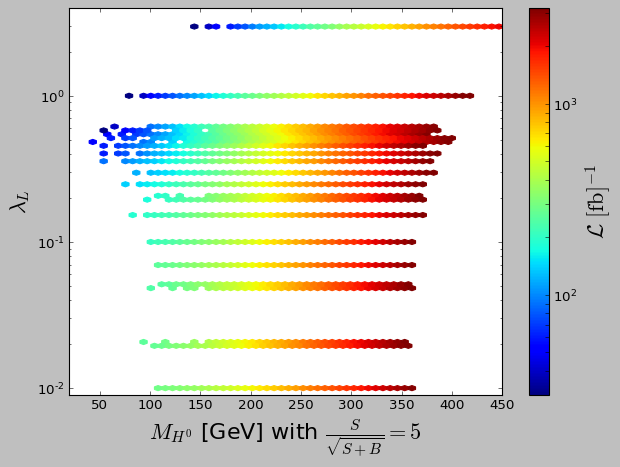

In [8]:
df=df[df.MH0_excl>0]
plt.hexbin(df.MH0_excl,df.LaL,df.Luminosity/1000.,yscale='log',norm=LogNorm())
ax=plt.colorbar()#ticks=[30,100,300,500,700,1000,3000])
#ax.set_ticklabels([30,100,300,1000,3000])
ax.set_label(r'${\cal L}\ [{\rm fb}]^{-1}$',size=20)
plt.xlim(20,450)
plt.ylim(9E-3,4)
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lc.pdf')
#plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m')
#plt.plot(lower.MH0_excl,lower.LaL,'ko')

In [18]:
np.sort(dfl.LaL.unique())[::-1]

array([ 0.6 ,  0.55,  0.5 ,  0.45,  0.4 ,  0.35,  0.3 ,  0.25,  0.2 ,
        0.15,  0.1 ,  0.07,  0.05,  0.02,  0.01])

In [23]:
maxLaL=0.55
dfl=df[df.LaL<maxLaL]

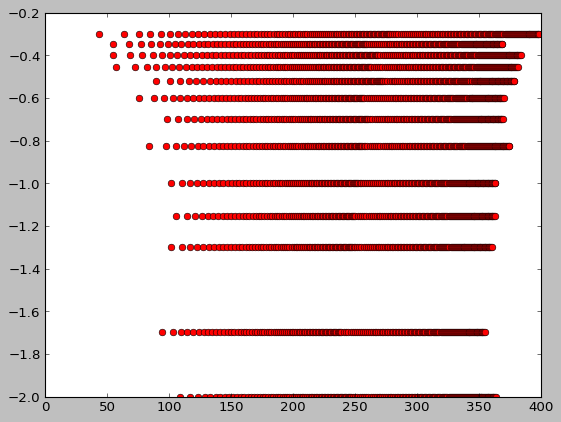

In [24]:
plt.plot(dfl.MH0_excl,np.log10(dfl.LaL),'ro')

In [25]:
mf=[];lf=[]
for l in np.sort(dfl.LaL.unique())[::-1]:
    xx,yy=dfl[dfl.LaL==l].MH0_excl.min(),l
    mf.append(xx);lf.append(yy)

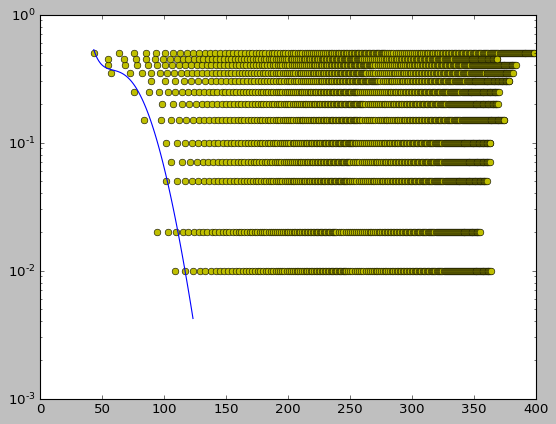

In [47]:
pw=3
plt.semilogy(dfl.MH0_excl,dfl.LaL,'yo')
#plt.plot(mf,lf,'k',lw=2)
lf=curvefit(mf,lf)
lf.add_fit(pw,ShowPlot=False)
x=np.arange(mf[0],mf[-1]+15)
plt.plot(x,lf(x))

In [42]:
df_full=df.copy()

In [ ]:
plt.hexbin(df.MH0_excl,df.LaL,df.Luminosity/1000.,yscale='log',norm=LogNorm())

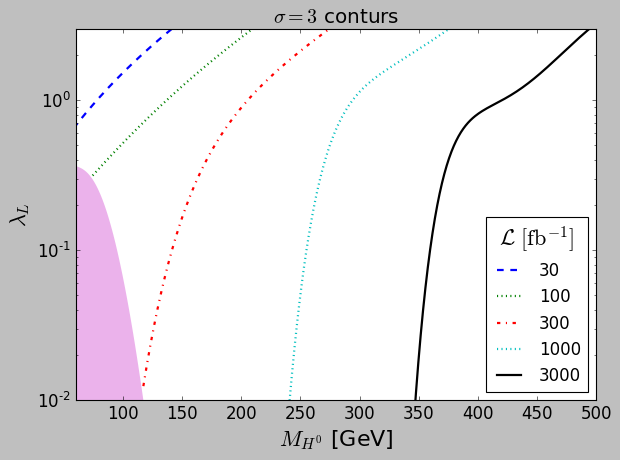

In [89]:
Dots=False
Lumis=[30000.,100000.,300000,1000000.,3000000.]
plt.rcParams.update({'font.size': 15})
line_format=['b--','g:','r-.','c:','k-']
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    sf=curvefit(sd.MH0_excl,sd.LaL)
    #Special cases
    pw=5
    fix_beg=0
    if Lumi==30000:
        pw=2
        fix_beg=10
    if  Lumi==100000:
        fix_beg=-2
        pw=2
    if Lumi==3000000:
        pw=6
        fix_beg=10

    #if Lumi==300000:
    #    pw=3        
    sf.add_fit(pw,ShowPlot=False)
    x=np.arange(sd.MH0_excl.min()-fix_beg,sd.MH0_excl.max())
    plt.semilogy( x, sf(x),line_format[i],label='%d' %int(Lumi/1000) ,lw=2 ) 
    if Dots:
        plt.semilogy( sd.MH0_excl, sd.LaL,'r*' ) 
    i=i+1

    

xlf=np.arange(mf[0],mf[-1]+15)
plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m',lw=0)
leg=plt.legend(loc='lower right',prop={'size':15})
leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(60,500)
plt.ylim(1.E-2,3)    
plt.title('$\sigma=3$ conturs' )
plt.xlabel(r'$M_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lcf.pdf')

In [43]:
df=pd.DataFrame()
for L in [30000.,100000.,300000,1000000.,3000000.]:
    df=df.append(df_full[df_full.Luminosity==L],ignore_index=True)

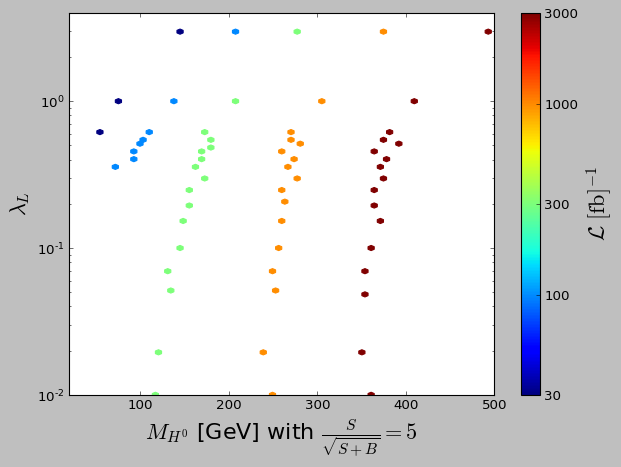

In [46]:
df=df[df.MH0_excl>0]
plt.hexbin(df.MH0_excl,df.LaL,df.Luminosity/1000.,yscale='log',norm=LogNorm())
ax=plt.colorbar(ticks=[30,100,300,1000,3000])
ax.set_ticklabels([30,100,300,1000,3000])
ax.set_label(r'${\cal L}\ [{\rm fb}]^{-1}$',size=20)
plt.xlim(20,500)
plt.ylim(1E-2,4)
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lc.pdf')

In [ ]:
plt.rcParams.update({'font.size': 15})
lower=pd.DataFrame()
store_lower=True
points=False
line_format=['b--','g:','r-.','c:','k-']
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    sf=curvefit(sd.MH0_excl,sd.LaL)
    #Special cases
    pw=5
    if Lumi==30000:
        pw=2

    if Lumi==300000:
        pw=3        
    sf.add_fit(pw,ShowPlot=False)
    x=np.arange(sd.MH0_excl.min(),sd.MH0_excl.max())
    if store_lower:
        ymin=sd.LaL.min()
        get_point=sd[sd.LaL==ymin]
        if get_point.shape[0]==1:
            lower=lower.append(get_point[['MH0_excl','LaL']],ignore_index=True)
  
        print(ymin,df.LaL.min())
    if ymin==df.LaL.min():
        store_lower=False    
    
    if points:
        plt.semilogy( sd.MH0_excl, sd.LaL,'ro')
    plt.semilogy( x, sf(x),line_format[i],label='%d' %int(Lumi/1000) ,lw=2 ) 
    i=i+1

    

lf=curvefit(lower.MH0_excl,lower.LaL)
lf.add_fit(4,ShowPlot=False)
xlf=np.arange( lower.MH0_excl.min(),lower.MH0_excl.max()  )
plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m')
leg=plt.legend(loc='lower right',prop={'size':15})
leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(60,460)
plt.ylim(1.3E-2,4)    
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lcf.pdf')

(0.01, 1)

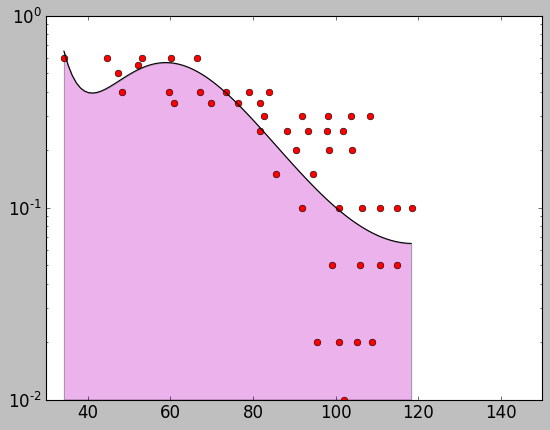

In [135]:
plt.rcParams.update({'font.size': 15})
lower=pd.DataFrame()
store_lower=True
points=False
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    x=np.arange(sd.MH0_excl.min(),sd.MH0_excl.max())
    if store_lower:
        ymin=sd.LaL.min()
        get_point=sd[sd.LaL==ymin]
        if get_point.shape[0]==1:
            lower=lower.append(get_point[['MH0_excl','LaL']],ignore_index=True)
  
    if ymin==df.LaL.min():
        store_lower=False    
    
    i=i+1

    

plt.plot(lower.MH0_excl,lower.LaL,'ro')
lf=curvefit(lower.MH0_excl,lower.LaL)
lf.add_fit(4,ShowPlot=False)
xlf=np.arange( lower.MH0_excl.min(),lower.MH0_excl.max()  )
plt.semilogy(xlf,lf(xlf),'k-')
plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m')
#leg=plt.legend(loc='lower right',prop={'size':15})
#leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(30,150)
plt.ylim(1.E-2,1)    

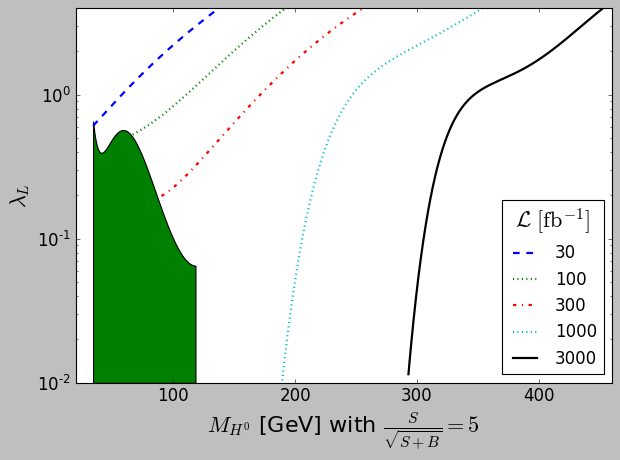

In [125]:
Lumis=[30000.,100000.,300000,1000000.,3000000.]
plt.rcParams.update({'font.size': 15})
line_format=['b--','g:','r-.','c:','k-']
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    sf=curvefit(sd.MH0_excl,sd.LaL)
    #Special cases
    pw=5
    if Lumi==30000:
        pw=2

    if Lumi==300000:
        pw=3        
    sf.add_fit(pw,ShowPlot=False)
    x=np.arange(sd.MH0_excl.min(),sd.MH0_excl.max())
    plt.semilogy( x, sf(x),line_format[i],label='%d' %int(Lumi/1000) ,lw=2 ) 
    i=i+1

    

xlf=np.arange( lower.MH0_excl.min(),lower.MH0_excl.max()  )
plt.fill_between(xlf,lf(xlf),0.01,alpha=1,facecolor='g')
leg=plt.legend(loc='lower right',prop={'size':15})
leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(20,460)
plt.ylim(1.E-2,4)    
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lcf.pdf')

In [212]:
pd.DataFrame().shape[0]

0

In [211]:
sd.LaL.min()

0.40000000000000002

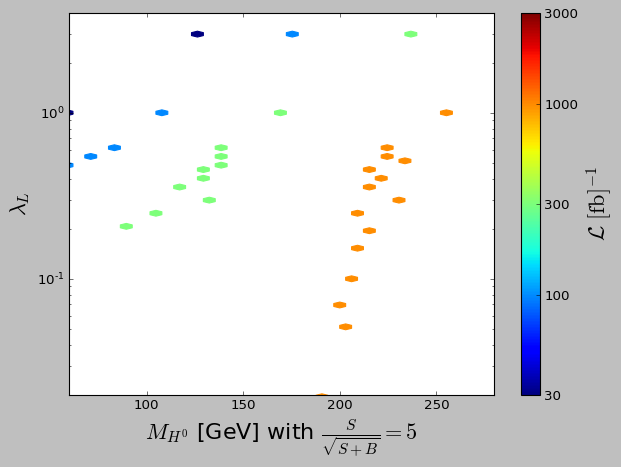

In [129]:
df=df[df.MH0_excl>0]
plt.hexbin(df.MH0_excl,df.LaL,df.Luminosity/1000.,yscale='log',norm=LogNorm())
ax=plt.colorbar(ticks=[30,100,300,1000,3000])
ax.set_ticklabels([30,100,300,1000,3000])
ax.set_label(r'${\cal L}\ [{\rm fb}]^{-1}$',size=20)
plt.xlim(60,280)
plt.ylim(2E-2,4)
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lc.pdf')

In [92]:
#if True:
MHp=700;LaL1=10;crossing_plot=False
Lumis=np.logspace(np.log10(30),np.log10(3000),101)
for LaL1 in df.LaL.unique():
    print(LaL1)
    for Lumi in Lumis:    
        dffix=df[ np.logical_and( np.logical_and(df.MHp==MHp,df.Luminosity==Lumi),\
                  df.LaL==LaL1              )]
        df_match=dffix.index.values
        #print(Lumi,df_match[0])
        dffix=dffix.reset_index(drop=True)
        if not dffix.shape[0]:
            sys.exit('LaL=%g not found in data' %LaL1)

        cf=curvefit(dffix.MH0[0],dffix.Significance[0])
        cf.add_fit(2,ShowPlot=False)


        x = np.arange(dffix.MH0[0][0]-50,dffix.MH0[0][-1]+300, 0.05)
        idx = np.argwhere(np.diff(np.sign (cf(x) - g(x,excl=excl) )) != 0).reshape(-1) + 0#
        excl_d={'M':0,'Sgnf':excl}
        if idx.shape[0]:
            excl_d={'M':x[idx[0]],'Sgnf':cf(x)[idx[0]]}
            if df_match.shape[0]:
                df.loc[df_match[0],'MH0_excl']=excl_d['M']
                df.loc[df_match[0],'Sgnf_excl']=excl_d['Sgnf']


        if crossing_plot:
            #dffix['MH0_excl']=excl['M']
            plt.semilogy(x,cf(x))
            plt.semilogy(x,g(x))
            plt.plot(excl_d['M'],excl_d['Sgnf'] , 'ro')

0.1


SystemExit: LaL=0.1 not found in data

## Full data with full luminosities for $M_{H^\pm}=250$ GeV

In [ ]:
MHp=250 #MH+
Lumis=[30000.,100000.,300000.,3000000.]
LaL=np.array([0.01,0.1,0.5,1.0,5.0,10.0])
MH0=np.array([70,75,80,85,90,110,130,150,190,210,220,240])
XS=np.array([[0.0349202532,0.0334004548,0.0317959539,0.0299136009,0.0284446578,0.0231171019,0.0182469057,0.0145908085,0.0032957252,0.0008311599,0.0002327398,2.69170669596E-005],[0.0401153803,0.0365328119,0.0339879003,0.0318100305,0.0299869285,0.0236790908,0.018614465,0.0148075782,0.0033628365,0.0008528258,0.0002575083,3.76243302046E-005],[0.1292954556,0.0877346517,0.0671422842,0.055387881,0.0473004018,0.0303751277,0.0220217644,0.0166179432,0.003983908,0.0012414054,0.0005508421,0.000212817],[0.3925881269,0.235609451,0.163829771,0.1215055018,0.0961519127,0.0487745888,0.0302338164,0.0211453691,0.0056017643,0.002215103,0.0013337227,0.0007131346],[8.8106015968,4.9330438839,3.2202837071,2.2445297762,1.6530410394,0.6298478626,0.2986637424,0.1646727753,0.0551913027,0.0339149853,0.0267049906,0.0175325777],[37.5523833824,21.5683403078,14.1510102501,10.1290781829,7.4208955246,2.883369972,1.3888054495,0.750051374,0.260519149,0.1647700939,0.1322070255,0.0871119659]])
Eff=np.array([[0.10438413361169102, 0.5230125523012552, 1.142263759086189, 1.3555787278415015, 1.4462809917355373, 1.2461059190031152], [0.2066115702479339, 0.625, 0.9394572025052192, 1.3499480789200415, 2.2821576763485476, 0.8359456635318704], [0.2070393374741201, 0.4175365344467641, 1.2396694214876034, 0.9297520661157025, 1.6684045881126173, 1.9771071800208118], [0.10471204188481675, 0.1037344398340249, 1.5723270440251573, 1.2474012474012475, 1.6528925619834711, 1.037344398340249], [0.0, 0.10482180293501048, 0.8221993833504625, 1.4598540145985401, 0.82389289392379, 1.435897435897436], [0.20639834881320948, 0.31088082901554404, 1.1387163561076605, 1.45681581685744, 1.3347022587268993, 0.8264462809917356], [0.20639834881320948, 0.30991735537190085, 0.6211180124223602, 1.5321756894790604, 2.5693730729701953, 1.0245901639344261], [0.2074688796680498, 0.10330578512396695, 0.8171603677221655, 1.2539184952978057, 1.6494845360824741, 1.7329255861365953], [0.0, 0.1180637544273908, 0.7821229050279329, 2.549889135254989, 2.378490175801448, 2.443991853360489], [0.684931506849315, 0.2604166666666667, 1.7921146953405018, 2.137232845894263, 2.6859504132231407, 3.8578680203045685], [1.0810810810810811, 1.4397905759162304, 3.939745075318656, 2.912621359223301, 3.615702479338843, 2.032520325203252], [3.814432989690722, 4.732510288065844, 3.6923076923076925, 2.3613963039014374, 2.5510204081632653, 2.443991853360489]])
for Lumi in Lumis:
    Significance=significance(XS,Eff,Lumi,TB)
    for i in range(LaL.shape[0]):
        df=df.append({'MHp':MHp,'Luminosity':Lumi,'LaL':LaL[i],'MH0':MH0,'XS':XS[i],'Eff':Eff.transpose()[i],\
                      'Significance':Significance.transpose()[i]},ignore_index=True)                 

In [51]:
i=16
df.loc[i,'MH0_excl'],df.loc[i,'LaL'],df.loc[i,'Luminosity']/1000.

(121.24999999999709, 3.0, 30.0)

In [75]:
df.LaL

0       0.01
1       0.02
2       0.05
3       0.07
4       0.10
5       0.15
6       0.20
7       0.25
8       0.30
9       0.35
10      0.40
11      0.45
12      0.50
13      0.55
14      0.60
15      1.00
16      3.00
17      5.00
18      7.00
19     10.00
20      0.01
21      0.02
22      0.05
23      0.07
24      0.10
25      0.15
26      0.20
27      0.25
28      0.30
29      0.35
       ...  
74      0.60
75      1.00
76      3.00
77      5.00
78      7.00
79     10.00
80      0.01
81      0.10
82      0.50
83      1.00
84      5.00
85     10.00
86      0.01
87      0.10
88      0.50
89      1.00
90      5.00
91     10.00
92      0.01
93      0.10
94      0.50
95      1.00
96      5.00
97     10.00
98      0.01
99      0.10
100     0.50
101     1.00
102     5.00
103    10.00
Name: LaL, dtype: float64

In [60]:
plt.setp()

https://stackoverflow.com/a/28766902/2268280
See also: https://stackoverflow.com/a/31541338/2268280    

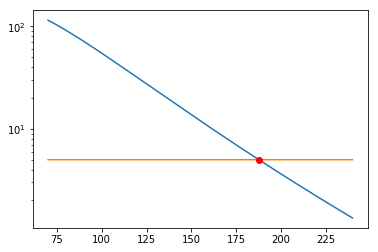

1

In [78]:
if np.argwhere( np.diff ( np.sign([4,3,2,1,0.5,-1,-2,-3])!=0 ) ).reshape(-1).shape[0]: print(1)

In [ ]:

g = -10 * np.arctan(x)

def intersection():
    idx = np.argwhere(np.isclose(y, g, atol=10)).reshape(-1)

In [37]:
#from scipy.optimize import fsolve
argw=np.argwhere(np.isclose(cf(x), g(x), atol=1E-3))

array([[2354]])

In [43]:
x[2354],cf(x)[2354]

(187.69999999999331, 4.9993978816309212)

In [30]:
np.argwhere(np.isclose(cf(x), g(x), atol=10)).reshape(-1)

array([1536, 1537, 1538, ..., 3397, 3398, 3399])

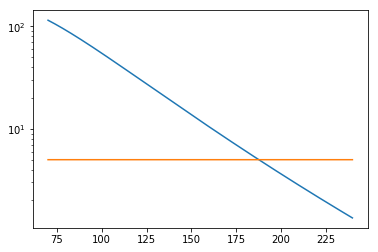

In [25]:
plt.semilogy(x,cf(x))
plt.semilogy(x,g(x))

File: Signif_dots_MHp_700_Lum_30.pdf created


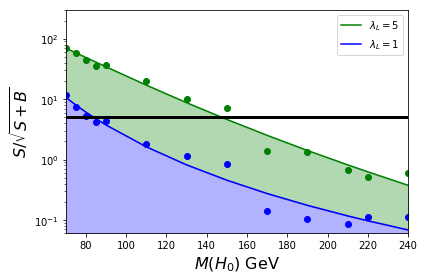

In [6]:
plot_fit(df,MHp=700,Lumi=30000,ymin=0.06,ymax=300,LaL1=5,LaL2=1,dots=True)

File: Signif_MHp_700_Lum_30.pdf created


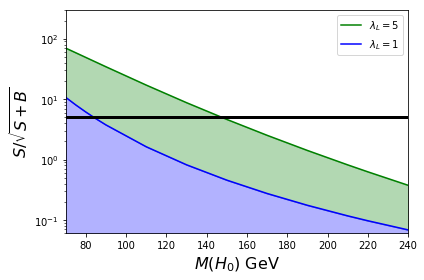

In [54]:
plot_fit(df,MHp=700,Lumi=30000,ymin=0.06,ymax=300,LaL1=5,LaL2=1,dots=False)

File: Signif_dots_MHp_250_Lum_30.pdf created


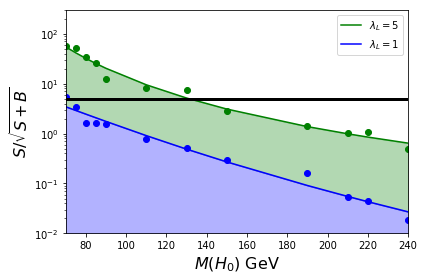

In [55]:
plot_fit(df,MHp=250,Lumi=30000,ymin=0.01,ymax=300,LaL1=5,LaL2=1,dots=True)

File: Signif_MHp_250_Lum_30.pdf created


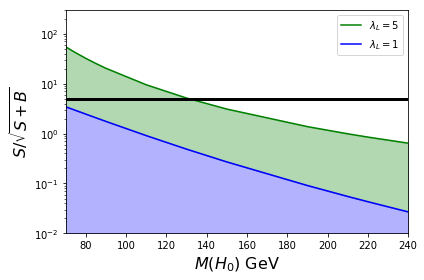

In [56]:
plot_fit(df,MHp=250,Lumi=30000,ymin=0.01,ymax=300,LaL1=5,LaL2=1,dots=False)

File: Signif_dots_MHp_700_Lum_100.pdf created


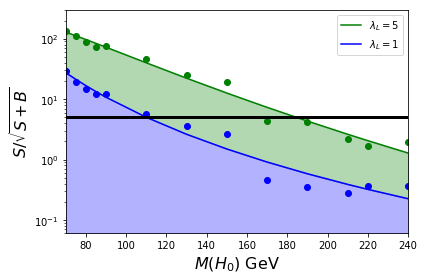

In [57]:
plot_fit(df,MHp=700,Lumi=100000.,ymin=0.06,ymax=300,LaL1=5,LaL2=1,dots=True)

File: Signif_MHp_700_Lum_100.pdf created


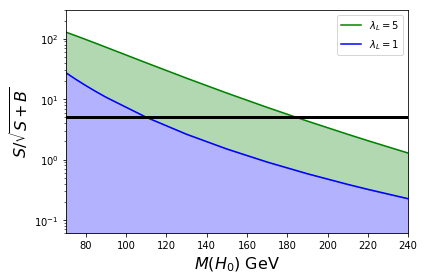

In [58]:
plot_fit(df,MHp=700,Lumi=100000.,ymin=0.06,ymax=300,LaL1=5,LaL2=1,dots=False)

File: Signif_dots_MHp_250_Lum_100.pdf created


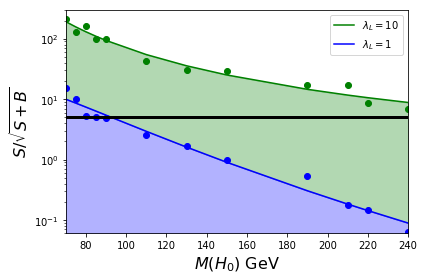

In [49]:
plot_fit(df,MHp=250,Lumi=100000.,ymin=0.06,ymax=300,LaL1=10,LaL2=1,dots=True)

File: Signif_MHp_250_Lum_100.pdf created


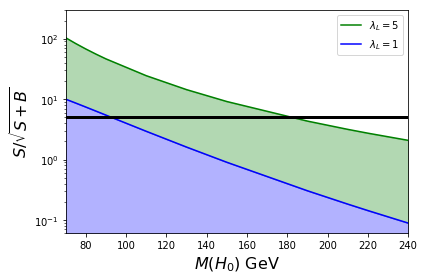

In [59]:
plot_fit(df,MHp=250,Lumi=100000.,ymin=0.06,ymax=300,LaL1=5,LaL2=1,dots=False)

## Low MH+=250 GeV 

# LUMINOSITY = 100 fb-1


## High MH+ 

In [18]:
Zvv=500.*(100./30) # Rescaling the expected background yield from 30 to 100 fb-1

TB=Zvv/0.7

def Z(S,B):
    return S/np.sqrt(S+B)

Lumi=100000.

LaL=np.array([0.01,0.02,0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,1.0,3.0,5.0,7.0,10.0])

MH0=np.array([70,75,80,85,90,110,130,150,170,190,210,220,240])

#XS Matrix MHO (rows) * LaL (columns)
XS=np.array([[0.00783607575629,0.00747482126337,0.0070754665236,0.0067536191246,0.0064510490936,0.00541729727502,0.00450514743728,0.00375921068237,0.00320540710897,0.00267848607156,0.00227665480784,0.00209697543768,0.00175175111731],[0.00820650858184,0.00777080218416,0.00734962798323,0.0069370100351,0.0066226838262,0.00552263250849,0.00459905776702,0.00384839961038,0.00321932258602,0.00266578919844,0.00224653784862,0.00206443852413,0.00175533185608],[0.00977036213144,0.00881650013264,0.00813644023049,0.00763551355176,0.00719752367893,0.00577411696313,0.00474742502055,0.00397919891226,0.00328311418054,0.00278081244384,0.00231507054359,0.00210931366709,0.00177590124026],[0.011420910156,0.00991723213372,0.0089898149608,0.00827525303364,0.00762911789735,0.00604103126321,0.00491831776786,0.00407360249129,0.00339849158687,0.00282520633474,0.00235567126882,0.00215982084251,0.00180423451155],[0.0141261425284,0.0115380580022,0.0100772508372,0.00913874460108,0.00830156542016,0.00640568666986,0.00510558102448,0.00419036053004,0.00346030010049,0.0028745840313,0.00239995296473,0.00218483771474,0.00184266632757],[0.0199244023107,0.0150710532694,0.0125500477084,0.0109981420566,0.00976696266413,0.0070938080392,0.00542679204951,0.00442523806302,0.00363703285801,0.00297419670822,0.00249216109259,0.00225890914297,0.00188309960197],[0.0271880899908,0.0197415176028,0.0158114945573,0.0133155110342,0.0117125410659,0.00799662341219,0.00602154446212,0.00473041583628,0.00385873942405,0.00315903944048,0.00254254399698,0.00233999204944,0.00194357104849],[0.0368390612651,0.0252109121861,0.0194860982444,0.0161147716505,0.0137569481748,0.00881569794804,0.0064548956078,0.005012030082,0.00405513563802,0.00323430260427,0.00265472306713,0.00243026454045,0.0019829645914],[0.0477417695661,0.0316975111695,0.0238740797744,0.0192376955626,0.0161976627504,0.00998088027677,0.00712239023152,0.00538841435699,0.00422531855685,0.00341865377609,0.00278731658182,0.00250914774171,0.00207481178219],[0.0597594640654,0.0391662561018,0.028821592883,0.022677722633,0.0188525187018,0.0111328469037,0.00775519019637,0.00574773540242,0.00451934291073,0.00355335003647,0.00289616277128,0.00261797622203,0.0021114508465],[0.0747956609518,0.0471382414448,0.0344983621758,0.0269670368818,0.0218295047684,0.0123661452119,0.00837222196693,0.00609279302469,0.00471057123249,0.00377991267025,0.00298606059531,0.00268121291098,0.00219558795724],[0.0910331287797,0.0567195719991,0.0403238163796,0.0310156215494,0.0250082748573,0.0136586156079,0.00907664301072,0.00658094533258,0.00500074299141,0.0039222600236,0.00312041844648,0.00277151342242,0.00228000711703],[0.107349388867,0.0656615481849,0.0465501253039,0.0360118243404,0.028576983123,0.0150524151214,0.00974113895248,0.0069750996649,0.00531461201434,0.00406819587094,0.00324091018643,0.00291883552383,0.00234128604466],[0.128043336128,0.0776237164167,0.0546097312013,0.0411755041257,0.0329947443675,0.0168543255501,0.0105431991354,0.00757444269303,0.00555879160621,0.00436459889587,0.00336931176585,0.00304028612383,0.00243809329108],[0.148695199269,0.090430645976,0.062674638844,0.0468132159563,0.0371150703981,0.018467720921,0.0116123492597,0.00802164436335,0.00582249375999,0.00456686473905,0.00353584411056,0.00318931593753,0.00255718993958],[0.380151397212,0.220473347428,0.148378942205,0.10656002523,0.0813605039088,0.0363423812252,0.020356914933,0.0130089520647,0.0090585052076,0.00652376877811,0.00489306516721,0.00423612392131,0.00329366179214],[3.24118473343,1.80212692796,1.17242330113,0.806867070297,0.603144333312,0.232872807677,0.114865352706,0.0646187944466,0.039699264752,0.0258472880513,0.0176354821901,0.0144681451833,0.0104482973562],[8.89427127628,4.92561586887,3.21912245078,2.25165545869,1.66314074829,0.635800506275,0.307443775785,0.168008418494,0.0996303321782,0.0623872431225,0.0417083022784,0.0340446574429,0.0238635636445],[17.8456821254,10.0440353143,6.56851555905,4.60076987107,3.39608947093,1.29049388377,0.62990145001,0.340561430381,0.198830653949,0.125181831838,0.082151306954,0.0657439627299,0.0453819909586],[38.1134563225,21.7394077983,14.2477022061,10.24165998,7.58446024417,2.96801902408,1.44282132676,0.785372567661,0.455678455194,0.281172708507,0.181313261152,0.145525755642,0.0986417773555]])

#Efficiency Matrix LaL (rows) * MH0 (columns)
Eff=np.array([[4.266389177939646, 5.104166666666667, 5.056759545923633, 4.855371900826446, 5.925155925155925, 6.029106029106029, 5.405405405405405, 3.9337474120082816, 5.882352941176471, 4.024767801857585, 3.711340206185567, 3.112033195020747, 2.883625128733265, 4.72764645426516, 2.7892561983471076, 3.4232365145228214, 2.8125, 2.158273381294964, 1.5432098765432098, 1.842374616171955],[4.878048780487805, 4.179728317659352, 6.139438085327783, 5.077720207253886, 5.807814149947202, 6.340956340956341, 4.916317991631799, 4.158004158004158, 4.488517745302714, 5.318039624608968, 4.583333333333333, 4.126984126984127, 4.612159329140461, 3.905447070914697, 4.564315352697095, 3.374233128834356, 3.58974358974359, 2.6859504132231407, 2.4691358024691357, 1.8329938900203666],[4.1623309053069715, 5.090137857900318, 4.680851063829787, 7.142857142857143, 5.7591623036649215, 4.702194357366771, 5.2301255230125525, 5.735140771637122, 5.192107995846314, 5.648535564853557, 6.521739130434782, 5.104166666666667, 4.72193074501574, 4.2752867570385815, 3.7267080745341614, 3.4161490683229814, 3.4055727554179565, 2.674897119341564, 3.501544799176107, 1.629327902240326],[5.186721991701245, 5.175983436853002, 6.15866388308977, 5.38860103626943, 4.311251314405888, 3.473684210526316, 4.512067156348373, 5.08298755186722, 5.175983436853002, 6.204756980351603, 5.77124868835257, 4.235537190082645, 4.947368421052632, 4.8353909465020575, 4.658385093167702, 3.7460978147762747, 3.29557157569516, 2.579979360165119, 1.954732510288066, 1.5337423312883436],[6.673728813559322, 4.439746300211416, 5.857740585774058, 5.654450261780105, 5.69620253164557, 5.2356020942408374, 5.931321540062435, 4.668049792531121, 5.503634475597092, 4.916317991631799, 4.826862539349423, 5.136268343815513, 4.916317991631799, 4.569055036344756, 4.583333333333333, 5.104166666666667, 3.9215686274509802, 3.822314049586777, 2.263374485596708, 1.9387755102040816],[6.327800829875518, 5.077720207253886, 4.041450777202073, 6.309148264984227, 4.811715481171548, 3.907074973600845, 5.968586387434555, 4.483837330552659, 5.093555093555094, 5.077720207253886, 5.042016806722689, 4.7418335089567965, 6.1139896373057, 5.279503105590062, 5.584281282316443, 4.66321243523316, 3.71900826446281, 4.123711340206185, 3.4161490683229814, 2.7522935779816513],[5.368421052631579, 4.682622268470343, 4.72193074501574, 5.306971904266389, 5.368421052631579, 4.953560371517028, 6.197478991596639, 4.756980351602896, 5.368421052631579, 5.29595015576324, 7.210031347962382, 5.031446540880503, 4.6875, 7.596253902185223, 5.9436913451511995, 5.093555093555094, 3.9542143600416235, 3.508771929824561, 3.172978505629478, 3.711340206185567],[4.636459430979979, 5.219206680584551, 4.994686503719447, 4.37956204379562, 5.46218487394958, 6.342494714587738, 5.7591623036649215, 5.543933054393306, 6.282722513089006, 5.7531380753138075, 4.931794333683106, 5.323590814196242, 5.96234309623431, 5.383022774327122, 4.831932773109243, 5.8212058212058215, 4.747162022703819, 4.410256410256411, 2.7720739219712525, 3.873598369011213],[3.199174406604747, 4.43298969072165, 4.375, 3.008298755186722, 3.441084462982273, 3.067484662576687, 2.2082018927444795, 2.57201646090535, 1.9874476987447698, 1.8518518518518519, 2.57201646090535, 1.875, 1.981230448383733, 1.7782426778242677, 1.7838405036726128, 1.36986301369863, 1.2435233160621761, 1.256544502617801, 1.365546218487395, 1.0298661174047374],[4.241781548250265, 5.613305613305613, 4.016477857878476, 3.0239833159541187, 3.757828810020877, 2.7921406411582215, 3.125, 2.4870466321243523, 2.8095733610822062, 2.059732234809475, 3.490759753593429, 1.975051975051975, 1.5608740894901145, 1.4492753623188406, 1.9668737060041408, 1.4462809917355373, 1.7400204708290685, 1.954732510288066, 1.1506276150627615, 1.1482254697286012],[4.895833333333333, 3.4627492130115427, 4.712041884816754, 3.7735849056603774, 4.0582726326742975, 3.913491246138002, 3.586497890295359, 3.638253638253638, 3.4161490683229814, 3.209109730848861, 2.286902286902287, 2.47167868177137, 2.9804727646454263, 2.5906735751295336, 2.1761658031088085, 1.5657620041753653, 1.8691588785046729, 1.4553014553014554, 2.0876826722338206, 1.251303441084463],[5.3125, 6.145833333333333, 4.692387904066736, 4.075235109717869, 4.597701149425287, 3.653444676409186, 3.1023784901758016, 3.402061855670103, 4.253112033195021, 4.024767801857585, 3.8906414300736065, 3.0239833159541187, 3.2528856243441764, 3.2854209445585214, 3.490759753593429, 2.36382322713258, 2.7720739219712525, 1.3388259526261586, 1.5511892450879008, 1.9467213114754098],[4.149377593360996, 4.416403785488959, 4.6777546777546775, 4.054054054054054, 5.174234424498416, 4.248704663212435, 3.426791277258567, 3.3057851239669422, 3.6496350364963503, 2.272727272727273, 2.7139874739039667, 4.028925619834711, 3.319502074688797, 2.711157455683003, 3.209109730848861, 2.9958677685950414, 2.4896265560165975, 2.2540983606557377, 2.277432712215321, 1.3238289205702647]])

Evts=Lumi*(XS.transpose())*(Eff/100)

Significance=Z(Evts,TB)

Uncertainty=np.sqrt(0.1**2+(np.sqrt(30)/30)**2) #Uncertainty from 8 TeV analysis + statistical uncertainty from MC samples
print Uncertainty

0.208166599947


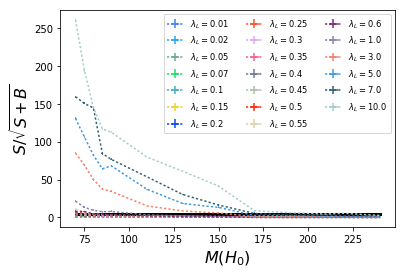

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in xrange(len(LaL)):
    ax.errorbar(MH0,Significance.transpose()[i], xerr=0.1, yerr=Uncertainty, linestyle='dotted', 
                label='$\lambda_{L}=$'+str(LaL[i]), color=np.random.rand(3,1))
#ax.errorbar(MH0,Significance.transpose()[0], xerr=0.1, yerr=Uncertainty, linestyle='dotted', label='$\lambda_{L}=0.01$')
#ax.errorbar(MH0,Significance.transpose()[-1], xerr=0.1, yerr=Uncertainty, linestyle='dotted', label='$\lambda_{L}=10.0$')
#ax.plot(MH0,Significance.transpose()[0],color="red",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[5],color="blue",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[10],color="green",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[15],color="yellow",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[18],color="magenta",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[-1],color="black",linestyle='solid')
ax.plot((MH0[0],MH0[-1]),(5.0,5.0),linewidth=3,color="black",linestyle='solid')
#ax.axhline(y=10.0, xmin=MH0[0], xmax=MH0[-1], linewidth=10, color = 'k')
#ax.set_yscale('log')
ax.set_ylabel(r'$S/\sqrt{S+B}$', fontsize=16)
ax.set_xlabel(r'$M(H_{0})$', fontsize=16)
legend = ax.legend(loc='upper right', shadow=False, fontsize='small', ncol=3)
plt.show()

[  -1.19405622  247.02716501]


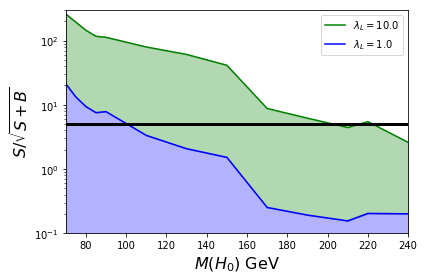

In [20]:
#def func(x,a,b,c):
#    return a+b*np.exp(c*x) #a+b*x+c*x**2
#####LambdaExp = lambda t,a,b,c: a*(b**(c*t))+70
#####x0 = np.array([0.0, 1.0, -1.0])
sigma1 = Significance.transpose()[-1]*0.1
sigma2 = Significance.transpose()[-5]*0.1
#FitResult1=optimization.curve_fit(func, MH0,Significance.transpose()[-1])
#####FitResult1=optimization.curve_fit(LambdaExp, MH0,Significance.transpose()[-1],p0=(140, -1.0))
FitResult1=np.polyfit(MH0,Significance.transpose()[-1],1)
print FitResult1
#FitResult1=optimization.curve_fit(func, MH0,Significance.transpose()[-1])
#FitResult2=optimization.curve_fit(func, MH0,Significance.transpose()[-5], x0, sigma2)

#Fill areas
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(MH0,Significance.transpose()[-1],color='g',linestyle='solid', label='$\lambda_{L}=10.0$')
#ax1.plot(MH0,LambdaExp(MH0, FitResult1[0][0], FitResult1[0][1]),
#         color='r',linestyle='solid', label='$\lambda_{L}=10.0$')
#ax1.plot(MH0,func(MH0, FitResult1[0][0], FitResult1[0][1], FitResult1[0][2], FitResult1[0][3], FitResult1[0][4]),
#         color='r',linestyle='solid', label='$\lambda_{L}=10.0$')
#ax1.plot(MH0,PolyNarray(MH0, FitResult1), color='r',linestyle='solid', label='$\lambda_{L}=10.0$')
ax1.plot(MH0,Significance.transpose()[-5],color='b',linestyle='solid', label='$\lambda_{L}=1.0$')
#ax1.plot(MH0,func(MH0, FitResult2[0][0], FitResult2[0][1], FitResult2[0][2], FitResult2[0][3], FitResult2[0][4]),
#         color='r',linestyle='solid', label='$\lambda_{L}=1.0$')
ax1.fill_between(MH0, Significance.transpose()[-1], Significance.transpose()[-5], color='green', alpha=0.3)
ax1.fill_between(MH0, Significance.transpose()[-5], np.zeros_like(Significance.transpose()[0])+0.06, color='blue', alpha=0.3)

#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left=MH0[0],right=MH0[-1])
ax1.set_ylim(bottom=0.1,top=300)
ax1.set_xlabel(r'$M(H_{0})$ GeV', fontsize=16)
ax1.set_ylabel(r'$S/\sqrt{S+B}$', fontsize=16)
ax1.plot((MH0[0],MH0[-1]),(5.0,5.0),linewidth=3,color="black",linestyle='solid')

legend1 = ax1.legend(loc='upper right', shadow=False)
plt.tight_layout()
plt.savefig('excls.pdf')